# Import des librairies

In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pickle

#scikit  preprocesing
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder

#scikit model
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression

#scikit metrics
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.metrics import confusion_matrix, roc_curve,auc
from sklearn.metrics import precision_score, recall_score, accuracy_score, classification_report, make_scorer
from sklearn.metrics import silhouette_score

#stats models
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan, het_white #homoscedasticité
from statsmodels.stats.outliers_influence import variance_inflation_factor #multicolinéarité
from statsmodels.stats.stattools import durbin_watson #autocorrelation
from statsmodels.graphics.gofplots import qqplot


#scipy
import scipy.stats as stats
from scipy.stats import t, shapiro
from scipy.stats import ttest_1samp #nullité des résidus
from scipy.special import boxcox1p

# Fonctions utiles

Commençons d'abord par définir des fonctions utiles

## Description Dataset

In [12]:
#Nous cherchons à créer une fonction qui nous permet de rapidement voir les : uniques, nan, le count, la fréquence, le min, le max, la moyenne, le nombre de ligne et de colonnes et le type

def describe_df(df):
    
    description=pd.DataFrame()
    description['dtype'] = df.dtypes
    description['missing_values'] = df.isnull().sum()
    description['unique_values'] = df.nunique()
    description['count']=df.count()
    description['min']=df.select_dtypes(include='number').min()
    description['max']=df.select_dtypes(include='number').max()
    description['moy']=round(df.select_dtypes(include='number').mean(),2)
    description['q1']=df.select_dtypes(include='number').quantile(0.25)
    description['med']=df.select_dtypes(include='number').quantile(0.5)
    description['q3']=df.select_dtypes(include='number').quantile(0.75)

    print(df.shape)
    print(df.duplicated().sum())
    
    return description

## Detection outliers

In [13]:
#Fonction de déctection outliers méthode IQR

def detect_outliers_iqr(dataframe):
    """
    Detect outliers in a pandas DataFrame using the interquartile range (IQR) method.

    Parameters:
    dataframe (pandas DataFrame): The DataFrame containing numerical data.

    Returns:
    dict: A dictionary where keys are column names and values are lists containing the indices of outliers.
    """
    outliers = {}
    for column in dataframe.select_dtypes(include='number'):
        quartile_1, quartile_3 = dataframe[column].quantile([0.25, 0.75])
        iqr = quartile_3 - quartile_1
        lower_bound = quartile_1 - (1.5 * iqr)
        upper_bound = quartile_3 + (1.5 * iqr)

        column_outliers = dataframe[(dataframe[column] < lower_bound) | (dataframe[column] > upper_bound)]
        outliers[column] = column_outliers
        display(outliers[column])
        print(outliers[column].shape)
        print(column_outliers.count())

In [14]:
#Fonction de déctection outliers méthode zscore

def detect_outliers_zscore(dataframe, threshold=3):
    """
    Detect outliers in a pandas DataFrame using the Z-score method.

    Parameters:
    dataframe (pandas DataFrame): The DataFrame containing numerical data.
    threshold (float): The Z-score threshold to identify outliers. Default is 3.

    Returns:
    dict: A dictionary where keys are column names and values are lists containing the indices of outliers.
    """
    outliers = {}
    for column in dataframe.select_dtypes(include='number'):
        z_scores = np.abs((dataframe[column] - dataframe[column].mean()) / dataframe[column].std())
        
        column_outliers = dataframe.index[z_scores > threshold].to_list()
        outliers[column] = column_outliers
        display(outliers[column])
        print(len(outliers[column]))

## Graph corrélation

In [15]:
#Utilisation de la fonction pour créer le graphique des corrélation lors de la pca

def correlation_graph(pca, 
                      x_y, 
                      features) : 
    """Affiche le graphe des correlations

    Positional arguments : 
    -----------------------------------
    pca : sklearn.decomposition.PCA : notre objet PCA qui a été fit
    x_y : list ou tuple : le couple x,y des plans à afficher, exemple [0,1] pour F1, F2
    features : list ou tuple : la liste des features (ie des dimensions) à représenter
    """

    # Extrait x et y 
    x,y=x_y

    # Taille de l'image (en inches)
    fig, ax = plt.subplots(figsize=(10, 9))

    # Pour chaque composante : 
    for i in range(0, pca.components_.shape[1]):

        # Les flèches
        ax.arrow(0,0, 
                pca.components_[x, i],  
                pca.components_[y, i],  
                head_width=0.07,
                head_length=0.07, 
                width=0.02, )

        # Les labels
        plt.text(pca.components_[x, i] + 0.05,
                pca.components_[y, i] + 0.05,
                features[i])
        
    # Affichage des lignes horizontales et verticales
    plt.plot([-1, 1], [0, 0], color='grey', ls='--')
    plt.plot([0, 0], [-1, 1], color='grey', ls='--')

    # Nom des axes, avec le pourcentage d'inertie expliqué
    plt.xlabel('F{} ({}%)'.format(x+1, round(100*pca.explained_variance_ratio_[x],1)))
    plt.ylabel('F{} ({}%)'.format(y+1, round(100*pca.explained_variance_ratio_[y],1)))
    plt.title("Cercle des corrélations (F{} et F{})".format(x+1, y+1))

    # Le cercle 
    an = np.linspace(0, 2 * np.pi, 100)
    plt.plot(np.cos(an), np.sin(an))  # Add a unit circle for scale

    # Axes et display
    plt.axis('equal')
    plt.show(block=False)

## Projection

In [16]:
#Utilisation de la fonction de projection

def display_factorial_planes(   X_projected, 
                                x_y, 
                                pca=None, 
                                labels = None,
                                clusters=None, 
                                alpha=1,
                                figsize=[10,8], 
                                marker="." ):
    """
    Affiche la projection des individus

    Positional arguments : 
    -------------------------------------
    X_projected : np.array, pd.DataFrame, list of list : la matrice des points projetés
    x_y : list ou tuple : le couple x,y des plans à afficher, exemple [0,1] pour F1, F2

    Optional arguments : 
    -------------------------------------
    pca : sklearn.decomposition.PCA : un objet PCA qui a été fit, cela nous permettra d'afficher la variance de chaque composante, default = None
    labels : list ou tuple : les labels des individus à projeter, default = None
    clusters : list ou tuple : la liste des clusters auquel appartient chaque individu, default = None
    alpha : float in [0,1] : paramètre de transparence, 0=100% transparent, 1=0% transparent, default = 1
    figsize : list ou tuple : couple width, height qui définit la taille de la figure en inches, default = [10,8] 
    marker : str : le type de marker utilisé pour représenter les individus, points croix etc etc, default = "."
    """

    # Transforme X_projected en np.array
    X_ = np.array(X_projected)

    # On définit la forme de la figure si elle n'a pas été donnée
    if not figsize: 
        figsize = (7,6)

    # On gère les labels
    if  labels is None : 
        labels = []
    try : 
        len(labels)
    except Exception as e : 
        raise e

    # On vérifie la variable axis 
    if not len(x_y) ==2 : 
        raise AttributeError("2 axes sont demandées")   
    if max(x_y )>= X_.shape[1] : 
        raise AttributeError("la variable axis n'est pas bonne")   

    # on définit x et y 
    x, y = x_y

    # Initialisation de la figure       
    fig, ax = plt.subplots(1, 1, figsize=figsize)

    # On vérifie s'il y a des clusters ou non
    c = None if clusters is None else clusters
 
    # Les points    
    #plt.scatter(   X_[:, x], X_[:, y], alpha=alpha, 
    #                    c=kmeans.labels_, cmap="Set1", marker=marker)
    sns.scatterplot(data=None, x=X_[:, x], y=X_[:, y], hue=c)

    # Si la variable pca a été fournie, on peut calculer le % de variance de chaque axe 
    if pca : 
        v1 = str(round(100*pca.explained_variance_ratio_[x]))  + " %"
        v2 = str(round(100*pca.explained_variance_ratio_[y]))  + " %"
    else : 
        v1=v2= ''

    # Nom des axes, avec le pourcentage d'inertie expliqué
    ax.set_xlabel(f'F{x+1} {v1}')
    ax.set_ylabel(f'F{y+1} {v2}')

    # Valeur x max et y max
    x_max = np.abs(X_[:, x]).max() *1.1
    y_max = np.abs(X_[:, y]).max() *1.1

    # On borne x et y 
    ax.set_xlim(left=-x_max, right=x_max)
    ax.set_ylim(bottom= -y_max, top=y_max)

    # Affichage des lignes horizontales et verticales
    plt.plot([-x_max, x_max], [0, 0], color='grey', alpha=0.8)
    plt.plot([0,0], [-y_max, y_max], color='grey', alpha=0.8)

    # Affichage des labels des points
    if len(labels) : 
        for i,(_x,_y) in enumerate(X_[:,[x,y]]):
            plt.text(_x, _y+0.05, labels[i], fontsize='14',ha='center',va='center') 

    # Titre et display
    plt.title(f"Projection des individus (sur F{x+1} et F{y+1})")
    plt.show()

## Score de l'estimateur

In [17]:
def score(estimator):
    '''compute ans print train and test score'''
    
    tr_score=estimator.score(X_train,y_train).round(4)
    te_score=estimator.score(X_test,y_test).round(4)
    
    print(f'score train : {tr_score} score test: {te_score}')

## Matrice de confusion

In [18]:
def confusion(y_test,y_pred):
    ''' display confusion matrix'''
    mat=pd.DataFrame(confusion_matrix(y_test,y_pred))
    mat.columns=(f'pred_{i}' for i in mat.columns)
    mat.index=(f'test_{i}' for i in mat.index)
    return mat

## Gridsearch

In [19]:
def resultize(grid):

    res=pd.DataFrame(grid.cv_results_)
    cols=[i for i in res.columns if 'split' not in i]
    res=res[cols]
    res=res.sort_values('min_both')

    return res.head()

# Import fichier

In [20]:
df = pd.read_csv('file:///C:/Users/boisj/Documents/Formation%20Openclassroom/Projet%2010/billets.csv', sep=';')
display(describe_df(df))
df.head()

(1500, 7)
0


,dtype,missing_values,unique_values,count,min,max,moy,q1,med,q3
is_genuine,bool,0,2,1500,NaN,NaN,NaN,NaN,NaN,NaN
diagonal,float64,0,159,1500,171.04,173.01,171.96,171.750,171.96,172.17
height_left,float64,0,155,1500,103.14,104.88,104.03,103.820,104.04,104.23
height_right,float64,0,170,1500,102.82,104.95,103.92,103.710,103.92,104.15
margin_low,float64,37,285,1463,2.98,6.90,4.49,4.015,4.31,4.87
margin_up,float64,0,123,1500,2.27,3.91,3.15,2.990,3.14,3.31
length,float64,0,336,1500,109.49,114.44,112.68,112.030,112.96,113.34


,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54


Nous allons remplacer les valeurs manquantes grâce à une régression linéaire. Nous allons d'abord étudié les outliers.

# Data cleaning

## Outliers et données manquantes

In [21]:
features_nb=df.select_dtypes(include='number').columns.to_list()
features=df.columns.to_list()
features

['is_genuine',
 'diagonal',
 'height_left',
 'height_right',
 'margin_low',
 'margin_up',
 'length']

In [22]:
detect_outliers_iqr(df)

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
729,True,171.04,103.84,103.64,4.22,3.36,112.70
828,True,172.92,103.55,103.94,4.78,3.27,113.55
842,True,172.89,103.77,104.24,4.12,3.01,113.72
1022,False,172.89,104.03,104.03,6.03,3.00,110.95
1142,False,171.04,104.23,104.22,4.87,3.56,111.54
1277,False,173.01,104.59,104.31,5.04,3.05,110.91
1388,False,171.05,104.09,104.50,4.72,3.10,112.44


(7, 7)
is_genuine      7
diagonal        7
height_left     7
height_right    7
margin_low      7
margin_up       7
length          7
dtype: int64


,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
224,True,172.12,103.20,103.92,4.46,3.26,113.44
292,True,172.09,103.14,103.81,4.88,3.01,113.69
1090,False,172.11,104.88,104.10,4.80,3.73,110.78
1150,False,171.79,104.86,104.34,5.39,3.14,113.02
1382,False,171.97,104.85,104.52,5.87,3.56,110.98


(6, 7)
is_genuine      6
diagonal        6
height_left     6
height_right    6
margin_low      6
margin_up       6
length          6
dtype: int64


,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
77,True,171.84,104.09,103.03,4.11,2.77,113.18
176,True,171.75,103.63,102.97,4.46,2.77,113.22
193,True,172.35,103.73,102.95,4.49,3.37,112.49
251,True,171.80,103.26,102.82,NaN,2.95,113.22
522,True,172.02,104.42,102.91,3.86,3.12,113.43
761,True,172.16,103.93,103.04,4.14,2.99,113.26
1199,False,172.03,104.32,104.87,4.49,3.77,111.04
1321,False,172.29,104.72,104.86,5.71,3.16,112.15
1331,False,172.32,104.60,104.83,4.84,3.51,112.55


(11, 7)
is_genuine      11
diagonal        11
height_left     11
height_right    11
margin_low      10
margin_up       11
length          11
dtype: int64


,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
1023,False,172.02,104.26,104.20,6.20,3.58,111.25
1027,False,171.63,104.02,104.66,6.70,3.28,111.28
1031,False,172.40,104.00,103.82,6.33,3.10,112.11
1041,False,171.77,104.12,104.42,6.65,3.63,111.53
1053,False,171.85,104.52,104.05,6.21,3.43,111.96
1075,False,172.02,104.51,103.69,6.23,3.39,112.35
1092,False,171.87,104.76,104.02,6.30,3.61,111.29
1110,False,171.73,104.32,104.07,6.56,3.30,112.80
1124,False,171.88,103.92,104.27,6.70,3.11,110.93
1133,False,171.79,103.99,103.67,6.16,3.52,110.93


(24, 7)
is_genuine      24
diagonal        24
height_left     24
height_right    24
margin_low      24
margin_up       24
length          24
dtype: int64


,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
664,True,172.05,103.70,103.75,5.04,2.27,113.55
1029,False,171.96,104.29,104.03,6.01,3.91,110.83
1270,False,171.26,104.22,104.07,4.78,3.81,112.88


(3, 7)
is_genuine      3
diagonal        3
height_left     3
height_right    3
margin_low      3
margin_up       3
length          3
dtype: int64


,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
1082,False,171.75,103.96,103.83,5.39,3.54,109.49
1355,False,171.68,103.89,103.70,5.97,3.03,109.97
1453,False,171.55,104.20,104.49,5.42,3.54,109.93


(3, 7)
is_genuine      3
diagonal        3
height_left     3
height_right    3
margin_low      3
margin_up       3
length          3
dtype: int64


In [23]:
detect_outliers_zscore(df, threshold=3)

[729, 828, 842, 1022, 1142, 1277]

6


[]

0


[0, 251, 522, 1484]

4


[1027, 1041, 1110, 1124, 1169, 1254, 1290, 1441, 1464]

9


[664, 1029]

2


[1082, 1355, 1453]

3


54 ouliers sont détéctés avec la métode interquartile, 24 avec la méthode zscore

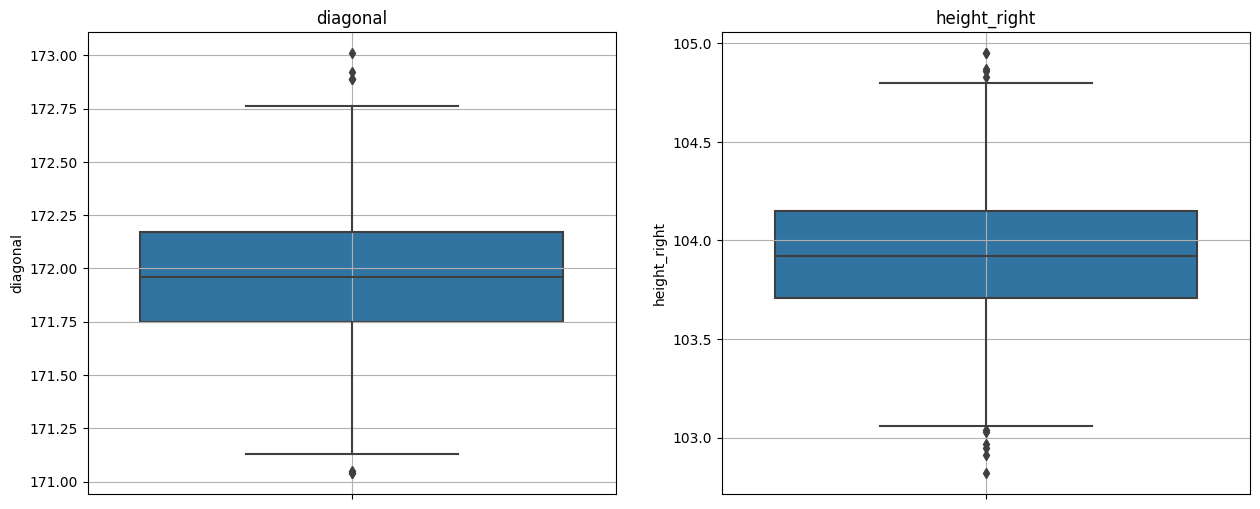

In [24]:
fig = plt.figure(figsize=(15, 6))

ax = fig.add_subplot(1, 2, 1)
sns.boxplot(data = df, y='diagonal')
ax.grid(True, which = 'both')
ax.set_title('diagonal')

ax = fig.add_subplot(1, 2, 2)
sns.boxplot(data = df, y='height_right')
ax.grid(True, which = 'both')
ax.set_title('height_right')
plt.show()

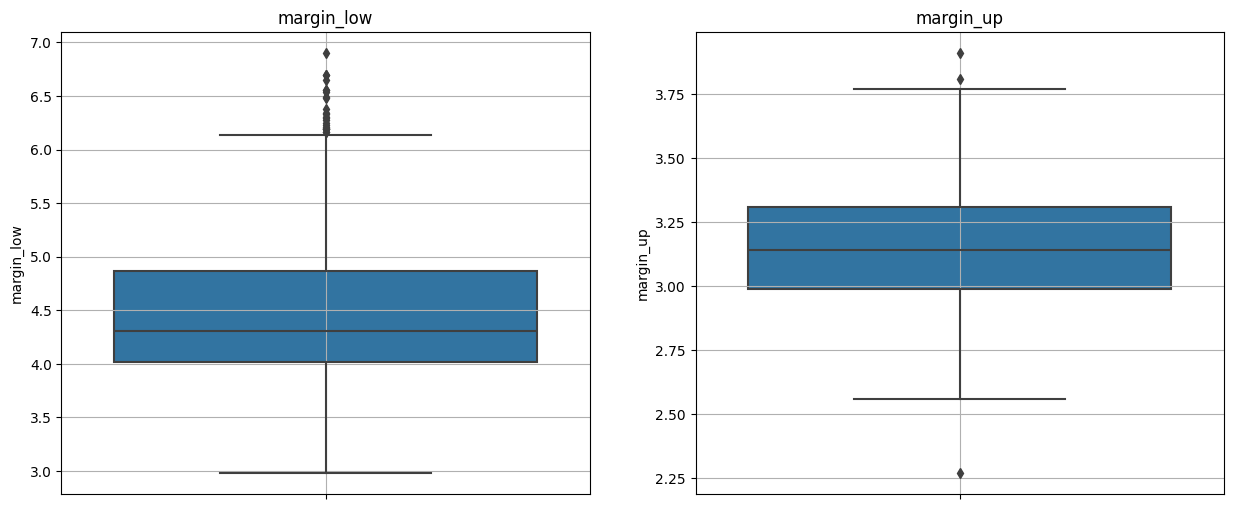

In [25]:
fig = plt.figure(figsize=(15, 6))

ax = fig.add_subplot(1, 2, 1)
sns.boxplot(data = df, y='margin_low')
ax.grid(True, which = 'both')
ax.set_title('margin_low')

ax = fig.add_subplot(1, 2, 2)
sns.boxplot(data = df, y='margin_up')
ax.grid(True, which = 'both')
ax.set_title('margin_up')
plt.show()

## Traitement outliers

Nous choississons de supprimer les 24 outliers détectés par la méthode z-score.

Les outliers peuvent influencer fortement les modèles de régression. Il est préférable de les enlever s'ils ne perturbent pas le jeu de données. Dans notre cas, j'ai fait le choix d'en supprimer un nombre limité en supprimant ceux de la méthode z-score. 

In [26]:
print('les outliers représentent ' + str(24/len(df)*100) + ' % des données')

les outliers représentent 1.6 % des données


In [27]:
outliers_supp=[729, 828, 842, 1022, 1142, 1277,0, 251, 522, 1484,1027, 1041, 1110, 1124, 1169, 1254, 1290, 1441, 1464,664, 1029,1082, 1355, 1453]
print('Nous avons ' + str(len(outliers_supp)) + ' outliers')

pd.DataFrame(outliers_supp).nunique()
#Nous n'avons pas de doublons

Nous avons 24 outliers


0    24
dtype: int64

In [28]:
df.loc[df.index.isin(outliers_supp)]

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
251,True,171.80,103.26,102.82,NaN,2.95,113.22
522,True,172.02,104.42,102.91,3.86,3.12,113.43
664,True,172.05,103.70,103.75,5.04,2.27,113.55
729,True,171.04,103.84,103.64,4.22,3.36,112.70
828,True,172.92,103.55,103.94,4.78,3.27,113.55
842,True,172.89,103.77,104.24,4.12,3.01,113.72
1022,False,172.89,104.03,104.03,6.03,3.00,110.95
1027,False,171.63,104.02,104.66,6.70,3.28,111.28
1029,False,171.96,104.29,104.03,6.01,3.91,110.83


Nos outliers sont présents dans des billets vrais et faux

In [29]:
df2=df.drop(outliers_supp)
df2.shape
df2.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54
5,True,172.17,103.74,104.08,4.42,2.95,112.81


In [30]:
describe_df(df2)

(1476, 7)
0


,dtype,missing_values,unique_values,count,min,max,moy,q1,med,q3
is_genuine,bool,0,2,1476,NaN,NaN,NaN,NaN,NaN,NaN
diagonal,float64,0,154,1476,171.05,172.76,171.96,171.7500,171.96,172.1700
height_left,float64,0,154,1476,103.14,104.88,104.03,103.8200,104.04,104.2300
height_right,float64,0,167,1476,102.95,104.87,103.92,103.7000,103.92,104.1425
margin_low,float64,36,278,1440,2.98,6.38,4.47,4.0100,4.31,4.8400
margin_up,float64,0,121,1476,2.56,3.81,3.15,2.9900,3.14,3.3100
length,float64,0,332,1476,110.22,114.44,112.69,112.0675,112.97,113.3500


## Régression linéaire multiple

### Numérisation des données et sous echantillon nan

On remplace la valeur Vraie / faux par 1 et 0

In [31]:
labelencoder=LabelEncoder()
df2['is_genuine']=labelencoder.fit_transform(df2['is_genuine'])
df2

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
1,1,171.46,103.36,103.66,3.77,2.99,113.09
2,1,172.69,104.48,103.50,4.40,2.94,113.16
3,1,171.36,103.91,103.94,3.62,3.01,113.51
4,1,171.73,104.28,103.46,4.04,3.48,112.54
5,1,172.17,103.74,104.08,4.42,2.95,112.81
...,...,...,...,...,...,...,...
1495,0,171.75,104.38,104.17,4.42,3.09,111.28
1496,0,172.19,104.63,104.44,5.27,3.37,110.97
1497,0,171.80,104.01,104.12,5.51,3.36,111.95
1498,0,172.06,104.28,104.06,5.17,3.46,112.25


Nous allons écarter les valeurs nan de notre entrainement, elle seront utilisées pour la validation

In [32]:
df2_nan=df2.loc[df['margin_low'].isna()]
df2_sans_nan=df2.drop(df2_nan.index)
describe_df(df2_sans_nan)

(1440, 7)
0


,dtype,missing_values,unique_values,count,min,max,moy,q1,med,q3
is_genuine,int64,0,2,1440,0.00,1.00,0.67,0.00,1.00,1.0000
diagonal,float64,0,153,1440,171.05,172.76,171.96,171.75,171.96,172.1700
height_left,float64,0,154,1440,103.14,104.88,104.03,103.82,104.04,104.2300
height_right,float64,0,167,1440,102.95,104.87,103.92,103.70,103.92,104.1425
margin_low,float64,0,278,1440,2.98,6.38,4.47,4.01,4.31,4.8400
margin_up,float64,0,121,1440,2.56,3.81,3.15,2.99,3.14,3.3100
length,float64,0,328,1440,110.22,114.32,112.69,112.06,112.97,113.3425


### Graphiques regplot

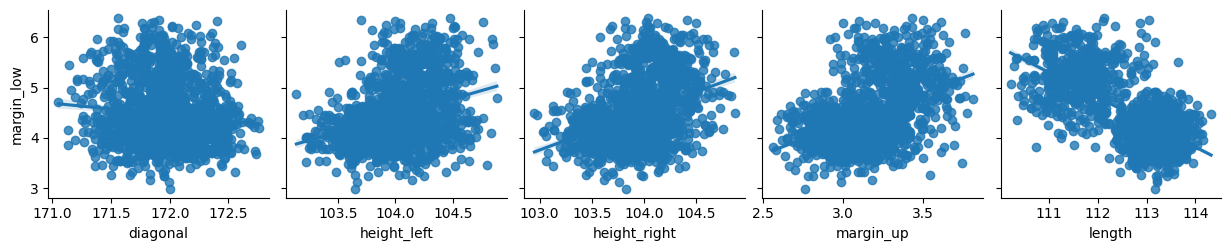

In [33]:
sns.pairplot(df2_sans_nan, x_vars=['diagonal', 'height_left', 'height_right','margin_up', 'length'], y_vars='margin_low', kind='reg')
plt.show()

### Split des data

In [34]:
X=df2_sans_nan.drop(columns='margin_low')
y=df2_sans_nan['margin_low']

### Normalisation des données

In [35]:
scaler = StandardScaler()

# on fit transforme nos données

X=scaler.fit_transform(X)

#on ajoute la constante
X = sm.add_constant(X)

### Entrainement du modèle

In [36]:
reg_lin_model=sm.regression.linear_model.OLS(y,X).fit()
print(reg_lin_model.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.620
Model:                            OLS   Adj. R-squared:                  0.618
Method:                 Least Squares   F-statistic:                     389.1
Date:                Tue, 11 Jun 2024   Prob (F-statistic):          1.53e-296
Time:                        13:04:06   Log-Likelihood:                -707.26
No. Observations:                1440   AIC:                             1429.
Df Residuals:                    1433   BIC:                             1465.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.4673      0.010    427.662      0.0

Avec la normalisation des données, nous avons perdus les nom des colonnes. Néanmoins, chaque variables est toujours présentes

In [37]:
pd.DataFrame(X,columns=['constante','is_genuine',
 'diagonal',
 'height_left',
 'height_right',
 'margin_up',
 'length']).head()

,constante,is_genuine,diagonal,height_left,height_right,margin_up,length
0,1.0,0.70159,-1.665049,-2.237889,-0.804095,-0.704017,0.466209
1,1.0,0.70159,2.434274,1.503215,-1.302839,-0.922110,0.547657
2,1.0,0.70159,-1.998328,-0.400740,0.068707,-0.616779,0.954897
3,1.0,0.70159,-0.765198,0.835161,-1.427525,1.433295,-0.173739
4,1.0,0.70159,0.701227,-0.968586,0.505108,-0.878491,0.140417


Pour affiner notre modèle, on peut supprimer les variables qui sont peu influentes, c'est à dire celles qui ont une p_value supérieure à 0.05.

Nous commençons par enlever 2nd variable (ici la diagonale)

In [38]:
X=np.delete(X,(2),axis=1)

In [39]:
reg_lin_model=sm.regression.linear_model.OLS(y,X).fit()
print(reg_lin_model.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.620
Model:                            OLS   Adj. R-squared:                  0.618
Method:                 Least Squares   F-statistic:                     467.2
Date:                Tue, 11 Jun 2024   Prob (F-statistic):          6.89e-298
Time:                        13:04:06   Log-Likelihood:                -707.28
No. Observations:                1440   AIC:                             1427.
Df Residuals:                    1434   BIC:                             1458.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.4673      0.010    427.804      0.0

Nous allons améliorer ce modèle en enlevant la 5ème variable soit la lenght

In [40]:
X=np.delete(X,(5),axis=1)

In [41]:
reg_lin_model=sm.regression.linear_model.OLS(y,X).fit()
print(reg_lin_model.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.620
Model:                            OLS   Adj. R-squared:                  0.619
Method:                 Least Squares   F-statistic:                     584.4
Date:                Tue, 11 Jun 2024   Prob (F-statistic):          2.75e-299
Time:                        13:04:06   Log-Likelihood:                -707.31
No. Observations:                1440   AIC:                             1425.
Df Residuals:                    1435   BIC:                             1451.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.4673      0.010    427.945      0.0

Nous allons améliorer ce modèle en enlevant la 3ème variable soit la height_right

In [42]:
X=np.delete(X,(3),axis=1)

In [43]:
reg_lin_model=sm.regression.linear_model.OLS(y,X).fit()
print(reg_lin_model.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.620
Model:                            OLS   Adj. R-squared:                  0.619
Method:                 Least Squares   F-statistic:                     779.7
Date:                Tue, 11 Jun 2024   Prob (F-statistic):          9.52e-301
Time:                        13:04:06   Log-Likelihood:                -707.36
No. Observations:                1440   AIC:                             1423.
Df Residuals:                    1436   BIC:                             1444.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.4673      0.010    428.080      0.0

Nous allons améliorer ce modèle en enlevant la 2ème variable soit la height_left

In [44]:
X=np.delete(X,(2),axis=1)

In [45]:
reg_lin_model=sm.regression.linear_model.OLS(y,X).fit()
print(reg_lin_model.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.619
Model:                            OLS   Adj. R-squared:                  0.619
Method:                 Least Squares   F-statistic:                     1169.
Date:                Tue, 11 Jun 2024   Prob (F-statistic):          4.36e-302
Time:                        13:04:06   Log-Likelihood:                -707.93
No. Observations:                1440   AIC:                             1422.
Df Residuals:                    1437   BIC:                             1438.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.4673      0.010    428.059      0.0

Nous avons la régression linéaire multiple qui prend en compte le type de billet et le margin_up. Le r² et R² ajusté sont de 0,62

### Prédiction sur l'ensemble

In [46]:
# On effectue la prédiction
predictions = reg_lin_model.predict(X)
predictions

array([4.12674055, 4.13671144, 4.12275219, ..., 5.18293974, 5.16299796,
       5.18094556])

In [47]:
# Evaluation du model

#RMSE
rmse = np.sqrt(mean_squared_error(y, predictions))

# Mape

MAPE = mean_absolute_percentage_error(y, predictions)

#r2
r2 = r2_score(y, predictions)

print("La performance du Modèle est")
print("------------------------------------------------")
print("l'erreur RMSE est " + str(round(rmse,3)))
print('le score R2 est ' + str(round(r2,3)))
print('le score MAPE score est ' + str(round(MAPE,3)))

La performance du Modèle est
------------------------------------------------
l'erreur RMSE est 0.396
le score R2 est 0.619
le score MAPE score est 0.069


nos scores de performance sont assez bon

### Evaluation de la régression linéaire

Avec algortihme de régression il faut faire les tests pour s'assurer de la bonne qualité du modèle avec l'analyse des résidus (distribution, vérification de la normalité des résidus et de l'hommodestacité des résidus

In [48]:
#Nous allons ici réaliser les tests à un niveau alpha=5% :

alpha=0.05

In [49]:
#Récupérons n, le nombre d'individus de l'échantillon, et p, le nombre de variables.
n = X.shape[0]
p = 3

In [50]:
#Nous allons mener des analyses sur les valeurs atypiques et/ou influentes en travaillant sur un dataframe appelé  analyses.
analyses = pd.DataFrame({'obs':np.arange(1, n+1)})
analyses['obs']=analyses['obs'].astype('float')
describe_df(analyses)

(1440, 1)
0


,dtype,missing_values,unique_values,count,min,max,moy,q1,med,q3
obs,float64,0,1440,1440,1.0,1440.0,720.5,360.75,720.5,1080.25


#### Calcul des leviers

In [51]:
analyses['levier'] = reg_lin_model.get_influence().hat_matrix_diag

seuil_levier = 2*p/n

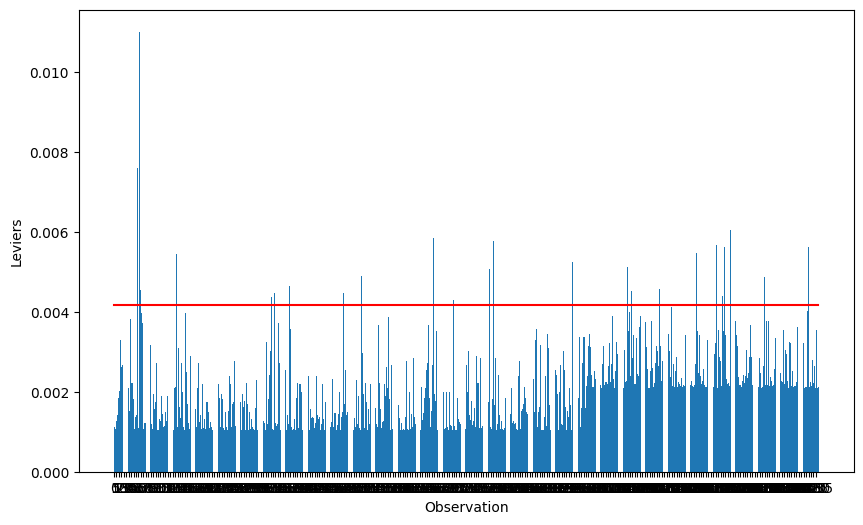

In [52]:
plt.figure(figsize=(10,6))
plt.bar(analyses['obs'], analyses['levier'])
plt.xticks(np.arange(0, 1440, step=5))
plt.xlabel('Observation')
plt.ylabel('Leviers')
plt.plot([0, 1440], [seuil_levier, seuil_levier], color='r')
plt.show()

In [53]:
# On sélectionne les points pour lesquels le levier est supérieur au seuil
analyses.loc[analyses['levier'] > seuil_levier, :]

,obs,levier
3,4.0,0.004889
47,48.0,0.007592
51,52.0,0.011009
53,54.0,0.004537
122,123.0,0.006048
...,...,...
1419,1420.0,0.005632
1420,1421.0,0.004568
1422,1423.0,0.004822
1424,1425.0,0.004976


#### Calculez les résidus studentisés

In [54]:
analyses['rstudent'] = reg_lin_model.get_influence().resid_studentized_internal
seuil_rstudent = t.ppf(1-alpha/2,n-p-1)

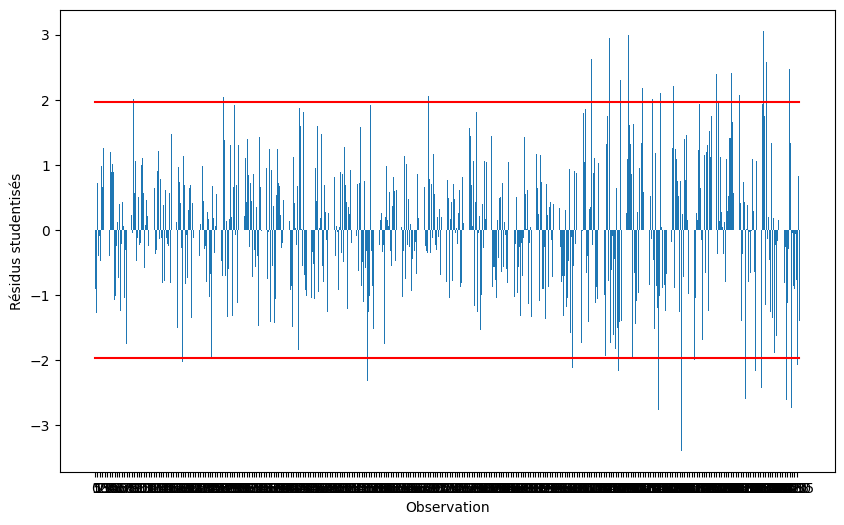

In [55]:
plt.figure(figsize=(10,6))
plt.bar(analyses['obs'], analyses['rstudent'])
plt.xticks(np.arange(0, 1440, step=5))
plt.xlabel('Observation')
plt.ylabel('Résidus studentisés')
plt.plot([0, 1440], [seuil_rstudent, seuil_rstudent], color='r')
plt.plot([0, 1440], [-seuil_rstudent, -seuil_rstudent], color='r')
plt.show()

#### Distance de cook

In [56]:
influence = reg_lin_model.get_influence().summary_frame()
analyses['dcooks'] = influence['cooks_d']
seuil_dcook = 4/(n-p)

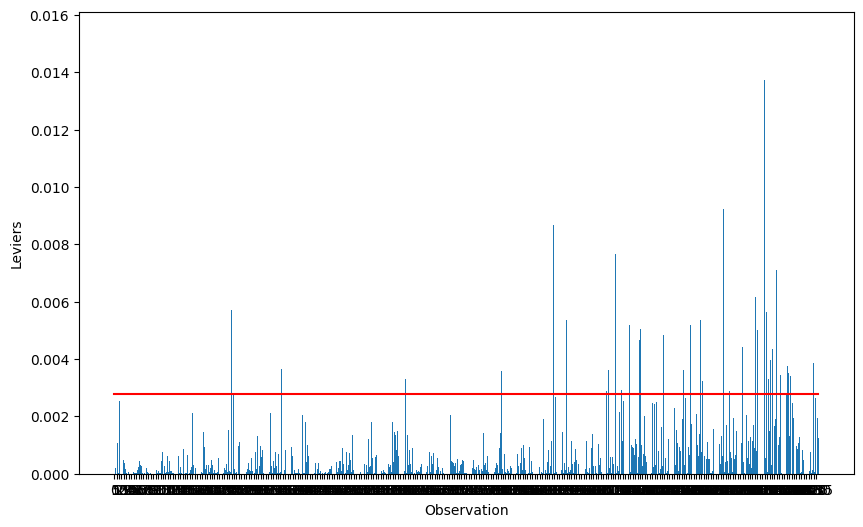

In [57]:
plt.figure(figsize=(10,6))
plt.bar(analyses['obs'], analyses['dcooks'])
plt.xticks(np.arange(0, 1440, step=5))
plt.xlabel('Observation')
plt.ylabel('Leviers')
plt.plot([0, 1440], [seuil_dcook, seuil_dcook], color='r')
plt.show()

#### Colinéarité des variables

In [58]:
#variables

variables=reg_lin_model.model.exog

[variance_inflation_factor(variables, i) for i in np.arange(1,variables.shape[1])]

[1.5990557311407063, 1.5990557311407065]

coefficients inférieures à 10 :  pas de problème de colinéarité

#### Test homoscédasticité

In [59]:
# Les résidus

predictions = reg_lin_model.predict(X)
residus = reg_lin_model.resid

On teste la constance de la variance des résidus

In [60]:
_, pval, __, f_pval = sm.stats.diagnostic.het_breuschpagan(residus, variables)
print('p value test Breusch Pagan:', pval)

p value test Breusch Pagan: 1.04518339917837e-34


La p-valeur ici est  inférieure à 5%, on  rejette  l'hypothèse H0 selon laquelle les variances sont constantes (l'hypothèse d’homoscédasticité).

#### Normalité des résidus

Normalité des résidus (Shapiro)

stats : 0.9965914487838745 
p-value : 0.0029078235384076834


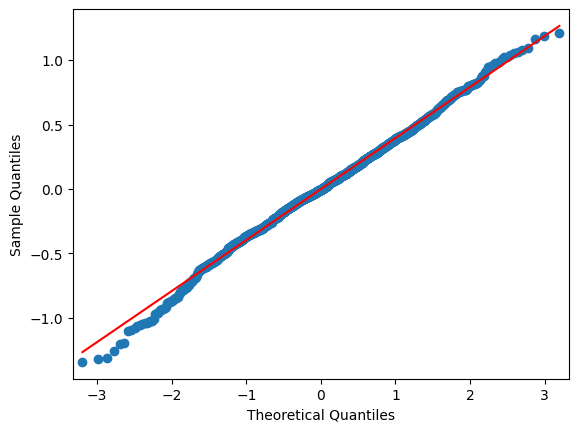

In [61]:
# Test de Shapiro sur les résidus
print('Normalité des résidus (Shapiro)')
print('\nstats :', stats.shapiro(residus)[0],
    '\np-value :', stats.shapiro(residus)[1])
qqplot(residus, line='s')
plt.show()

Ici, l'hypothèse de normalité est remise en cause.

Néanmoins, l'observation des résidus, le fait qu'ils ne soient pas très différents d'une distribution symétrique (voir ci-dessous), et le fait que l'échantillon soit de taille suffisante (supérieure à 30) permettent de dire que les résultats obtenus par le modèle linéaire gaussien ne sont pas absurdes, même si le résidu n'est pas considéré comme étant gaussien.

C:\Users\boisj\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


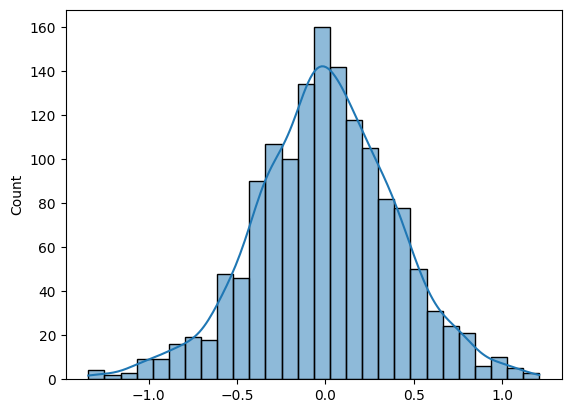

In [62]:
sns.histplot(residus,kde=True)
plt.show()

p_value inférieur à 0.05, distribution probablement pas normale

Normalité des résidus après boxcox :
stats : nan 
p-value : 1.0
H0 acceptée : distribution normale


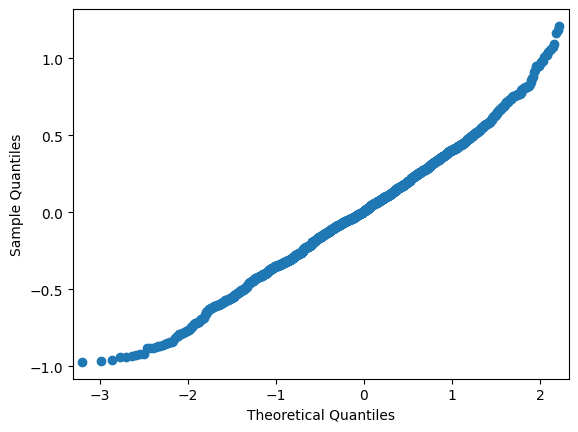

In [63]:
# Test de Shapiro sur les résidus après boxcox
residus2 = boxcox1p(residus, 1)
p = stats.shapiro(residus2)[1]
print('Normalité des résidus après boxcox :'
    '\nstats :', stats.shapiro(residus2)[0],
    '\np-value :', p)
if p>.05:
    print('H0 acceptée : distribution normale')
else:
    print('H0 rejetée : distribution probablement pas normale')
qqplot(residus2, line='s')
plt.show()

Après un boxcox distribution normale des résidus

#### Test t de Student

In [64]:
t_stat, p_value = ttest_1samp(residus, 0)

# Interprétation du test
alpha = 0.05 # Niveau de signification

print('Statistique du test t :' +  str(t_stat))
print('P-value : ' +  str(p_value))

if p_value < alpha:
    print('Rejeter l’hypothèse nulle : La moyenne des résidus est significativement différente de zéro.')
else:
    print('L’hypothèse nulle n’est pas rejetée : La moyenne des résidus n’est pas significativement différente de zéro.')

Statistique du test t :2.4721546834215624e-14
P-value : 0.9999999999999802
L’hypothèse nulle n’est pas rejetée : La moyenne des résidus n’est pas significativement différente de zéro.


### Remplacement des nan

In [65]:
a_prevoir=df2_nan[['is_genuine','margin_up']]
a_prevoir=scaler.fit_transform(a_prevoir)
a_prevoir=sm.add_constant(a_prevoir)

In [66]:
predict_val=reg_lin_model.predict(a_prevoir)
predict_val=predict_val.astype(float)
print(predict_val.shape)
print(predict_val)

(36,)
[4.15298031 4.17405335 4.19704212 4.08209826 4.19704212 4.15681177
 4.20087358 4.17788481 4.17022189 4.19895785 4.25642978 4.20470505
 4.14340165 4.25834551 4.28516575 4.18746347 4.18363201 4.15489604
 4.17596908 4.19895785 4.20278932 4.22003089 4.18746347 4.20470505
 4.28133429 4.19704212 4.14914885 4.20278932 5.43854851 5.44621143
 5.4749474  5.49218898 5.40214962 5.36191927 5.37149792 5.43280132]


In [67]:
df2['margin_low'].loc[df2['margin_low'].isnull()]=predict_val.round(2)

C:\Users\boisj\AppData\Local\Temp\ipykernel_7972\1530273631.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['margin_low'].loc[df2['margin_low'].isnull()]=predict_val.round(2)


In [68]:
describe_df(df2)

(1476, 7)
0


,dtype,missing_values,unique_values,count,min,max,moy,q1,med,q3
is_genuine,int64,0,2,1476,0.00,1.00,0.67,0.0000,1.00,1.0000
diagonal,float64,0,154,1476,171.05,172.76,171.96,171.7500,171.96,172.1700
height_left,float64,0,154,1476,103.14,104.88,104.03,103.8200,104.04,104.2300
height_right,float64,0,167,1476,102.95,104.87,103.92,103.7000,103.92,104.1425
margin_low,float64,0,279,1476,2.98,6.38,4.47,4.0200,4.30,4.8400
margin_up,float64,0,121,1476,2.56,3.81,3.15,2.9900,3.14,3.3100
length,float64,0,332,1476,110.22,114.44,112.69,112.0675,112.97,113.3500


# Analyse descriptive des données

## Graphiques

### Boxplot

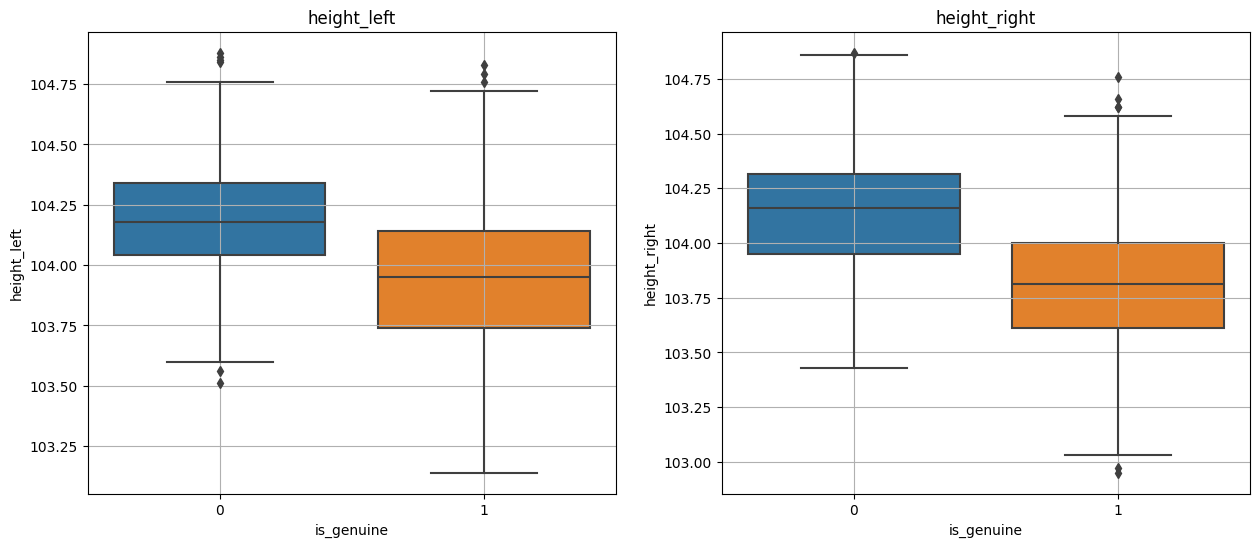

In [69]:
fig = plt.figure(figsize=(15, 6))

ax = fig.add_subplot(1, 2, 1)
sns.boxplot(data = df2, x='is_genuine', y='height_left')
ax.grid(True, which = 'both')
ax.set_title('height_left')

ax = fig.add_subplot(1, 2, 2)
sns.boxplot(data = df2, x='is_genuine', y='height_right')
ax.grid(True, which = 'both')
ax.set_title('height_right')
plt.show()

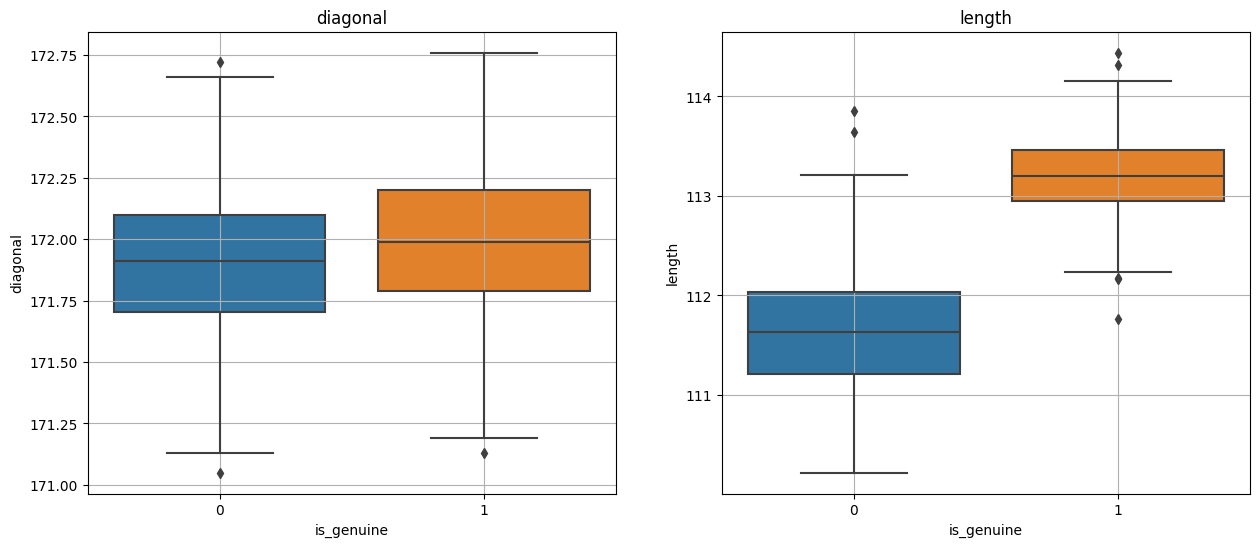

In [70]:
fig = plt.figure(figsize=(15, 6))
ax = fig.add_subplot(1, 2, 1)
sns.boxplot(data = df2, x='is_genuine', y='diagonal')
ax.grid(True, which = 'both')
ax.set_title('diagonal')

ax = fig.add_subplot(1, 2, 2)
sns.boxplot(data = df2, x='is_genuine', y='length')
ax.grid(True, which = 'both')
ax.set_title('length')

plt.show()

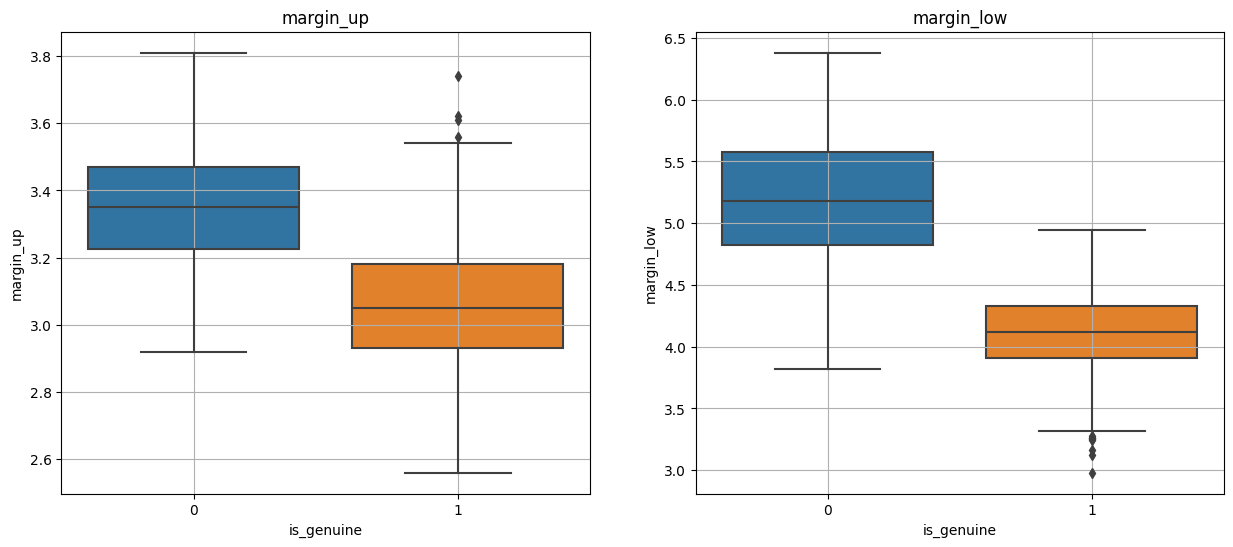

In [71]:
fig = plt.figure(figsize=(15, 6))
ax = fig.add_subplot(1, 2, 1)
sns.boxplot(data = df2, x='is_genuine', y='margin_up')
ax.grid(True, which = 'both')
ax.set_title('margin_up')

ax = fig.add_subplot(1, 2, 2)
sns.boxplot(data = df2, x='is_genuine', y='margin_low')
ax.grid(True, which = 'both')
ax.set_title('margin_low')

plt.show()

Visuellement on constate déjà des différences de distribution entre les faux et vrais billets sur chacune des variables

### Pairplot

C:\Users\boisj\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\boisj\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\boisj\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\boisj\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

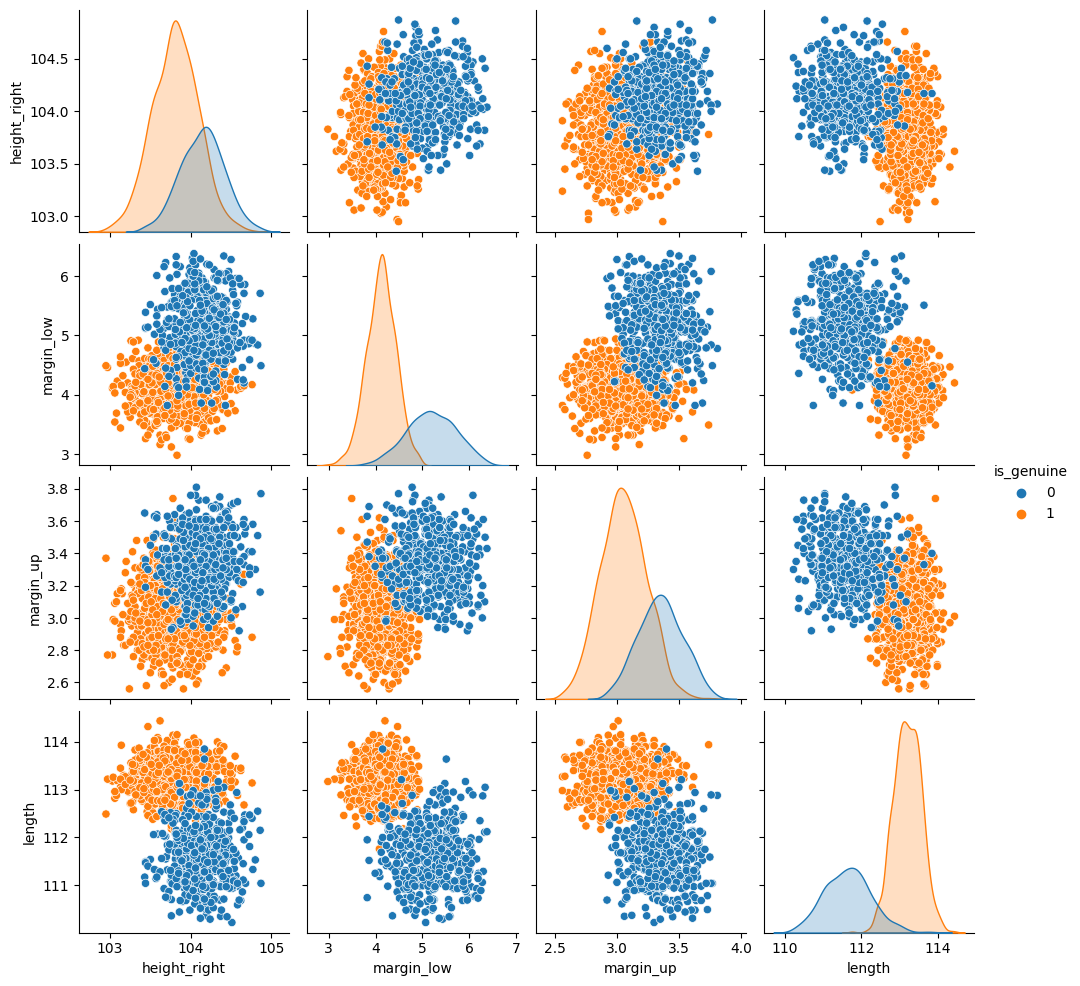

In [72]:
sns.pairplot(data=df2.drop(['diagonal','height_left'], axis=1), hue='is_genuine') #On se concentre sur les 4 variables vu ci-dessus
plt.show()

On remarque également des groupes bien séparés entre les valeures vraies et faux

### Matrice de corrélation

Avant d'effectuer une corrélation, il faut étudier si nos variables suivent toutes une loi gaussienne

In [73]:
# Sélectionner seulement les variables quantitatives
variables_quanti = df2.select_dtypes(include=['int64', 'float64']).columns

# Dictionnaire pour stocker les résultats
resultats_tests = []

# Boucle sur chaque colonne quantitative du DataFrame pour effectuer le test de normalité
for colonne in variables_quanti:
    stat, p_value = shapiro(df[colonne])

    niveau_significatif = 0.05
    normale = 'Oui' if p_value >= niveau_significatif else 'Non'

    resultats_tests.append({'Variable': colonne, 'Statistique de test': stat, 'P-valeur': p_value, 'Normale': normale})

# Créer un DataFrame à partir de la liste de résultats
df_resultats = pd.DataFrame(resultats_tests)

# Afficher les résultats à la fin
print('Résultats des tests de normalité :')
display(df_resultats)

Résultats des tests de normalité :


,Variable,Statistique de test,P-valeur,Normale
0,is_genuine,0.594887,0.000000e+00,Non
1,diagonal,0.998686,3.234359e-01,Oui
2,height_left,0.997901,5.093965e-02,Oui
3,height_right,0.999518,9.806054e-01,Oui
4,margin_low,NaN,1.000000e+00,Oui
5,margin_up,0.996166,8.104062e-04,Non
6,length,0.917601,7.863947e-28,Non


2 de nos variables ne suivent pas un loi gaussienne, plutôt qu'une corrélation de Pearson, on va utiliser celle de Spearman

C:\Users\boisj\anaconda3\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


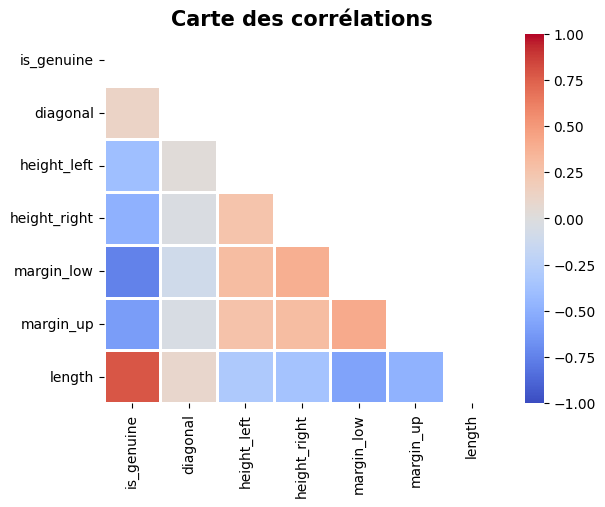

In [74]:
mask = np.triu(np.ones_like(df2.corr(method='spearman'), dtype=bool))
sns.heatmap(df2.corr(method='spearman'), mask=mask, center=0, 
                linewidths=1, annot=True, vmin=-1, vmax=1, cmap='coolwarm')
plt.title('Carte des corrélations', fontsize = 15, fontweight='bold')
plt.show()

In [75]:
df2.corr(method='spearman')

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
is_genuine,1.000000,0.124970,-0.396120,-0.488828,-0.747864,-0.609167,0.786153
diagonal,0.124970,1.000000,0.024052,-0.029485,-0.099494,-0.044873,0.088636
height_left,-0.396120,0.024052,1.000000,0.252056,0.303312,0.260672,-0.306357
height_right,-0.488828,-0.029485,0.252056,1.000000,0.389162,0.299289,-0.365103
margin_low,-0.747864,-0.099494,0.303312,0.389162,1.000000,0.413601,-0.578050
margin_up,-0.609167,-0.044873,0.260672,0.299289,0.413601,1.000000,-0.477305
length,0.786153,0.088636,-0.306357,-0.365103,-0.578050,-0.477305,1.000000


# Dataframe final après analyses

In [76]:
df2.to_csv('dataset_P10_sans_nan.csv',index=False)

# Classification

In [77]:
df = pd.read_csv('file:///C:/Users/boisj/dataset_P10_sans_nan.csv', sep=',')

In [78]:
display(describe_df(df))
display(df)

(1476, 7)
0


,dtype,missing_values,unique_values,count,min,max,moy,q1,med,q3
is_genuine,int64,0,2,1476,0.00,1.00,0.67,0.0000,1.00,1.0000
diagonal,float64,0,154,1476,171.05,172.76,171.96,171.7500,171.96,172.1700
height_left,float64,0,154,1476,103.14,104.88,104.03,103.8200,104.04,104.2300
height_right,float64,0,167,1476,102.95,104.87,103.92,103.7000,103.92,104.1425
margin_low,float64,0,279,1476,2.98,6.38,4.47,4.0200,4.30,4.8400
margin_up,float64,0,121,1476,2.56,3.81,3.15,2.9900,3.14,3.3100
length,float64,0,332,1476,110.22,114.44,112.69,112.0675,112.97,113.3500


,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,1,171.46,103.36,103.66,3.77,2.99,113.09
1,1,172.69,104.48,103.50,4.40,2.94,113.16
2,1,171.36,103.91,103.94,3.62,3.01,113.51
3,1,171.73,104.28,103.46,4.04,3.48,112.54
4,1,172.17,103.74,104.08,4.42,2.95,112.81
...,...,...,...,...,...,...,...
1471,0,171.75,104.38,104.17,4.42,3.09,111.28
1472,0,172.19,104.63,104.44,5.27,3.37,110.97
1473,0,171.80,104.01,104.12,5.51,3.36,111.95
1474,0,172.06,104.28,104.06,5.17,3.46,112.25


## Kmeans

Pour rappel : Vrai = 1 ; 
Faux = 0

In [79]:
df2=df.drop('is_genuine',axis=1) #on garde les valeurs numériques

In [80]:
df2=scaler.fit_transform(df2) #On normalise les données

### Elbow method

In [81]:
df_elbow=df2

In [82]:
# Une liste vide pour enregistrer les inerties :  

intertia_list = [ ]


#On défini  la liste du nombre de clusters que l'on veut tester
k_list = range(1, 10)

for k in k_list : 
    
    # On instancie un k-means pour k clusters
    kmeans = KMeans(n_clusters=k, n_init="auto")
    
    # On entraine
    kmeans.fit(df_elbow)
    
    # On enregistre l'inertie obtenue : 
    intertia_list.append(kmeans.inertia_)

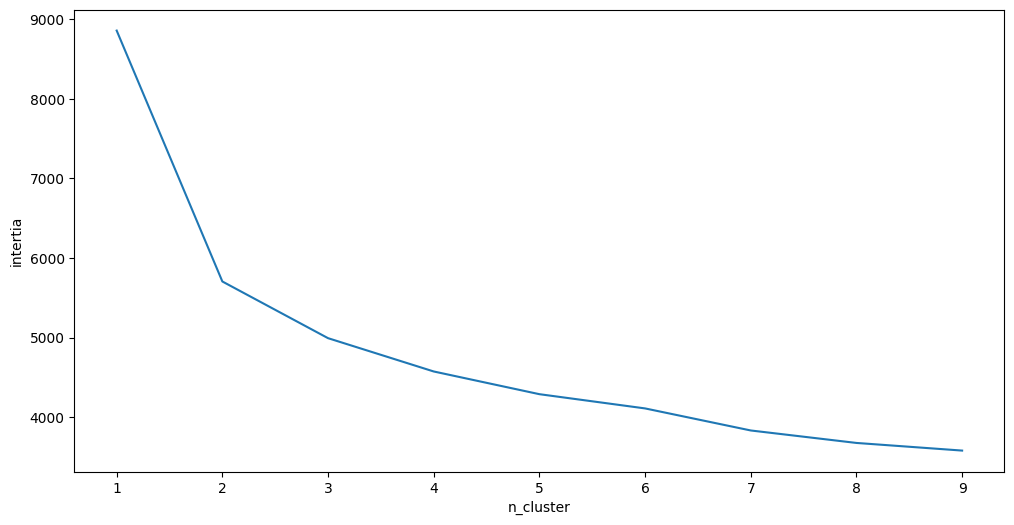

In [83]:
fig, ax = plt.subplots(1,1,figsize=(12,6))

ax.set_ylabel("intertia")
ax.set_xlabel("n_cluster")
ax = plt.plot(k_list, intertia_list)

Nous avons plusieurs cassures (2,3 et 4). Nous allons choisir la cassure 2 qui est la plus marquante. 

### Model kmeans

In [84]:
df_kmeans=df2
model = KMeans(n_clusters=2, n_init=10, random_state=42)
model.fit(df_kmeans)

KMeans(n_clusters=2, n_init=10, random_state=42)

### Performance du clustering en tant qu'outil de classification

In [85]:
labels = model.labels_.copy()
confusion(df['is_genuine'],labels)

,pred_0,pred_1
test_0,470,13
test_1,9,984


In [86]:
print(classification_report(df['is_genuine'],labels))

              precision    recall  f1-score   support

           0       0.98      0.97      0.98       483
           1       0.99      0.99      0.99       993

    accuracy                           0.99      1476
   macro avg       0.98      0.98      0.98      1476
weighted avg       0.99      0.99      0.99      1476



La performance du modèle est bonne

In [87]:
df_kmeans=pd.DataFrame(df2,columns=['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up','length'])
df_kmeans['cluster'] = labels
df_kmeans.head()

,diagonal,height_left,height_right,margin_low,margin_up,length,cluster
0,-1.663157,-2.238992,-0.801990,-1.092242,-0.696390,0.462647,1
1,2.436987,1.511081,-1.300118,-0.105394,-0.914086,0.544098,1
2,-1.996502,-0.397438,0.069733,-1.327206,-0.609312,0.951356,1
3,-0.763125,0.841425,-1.424649,-0.669307,1.437028,-0.177330,1
4,0.703593,-0.966646,0.505594,-0.074066,-0.870547,0.136840,1


In [88]:
#Répartition des clusters dans notre model kmeans
df_kmeans.groupby('cluster').count()

,diagonal,height_left,height_right,margin_low,margin_up,length
cluster,,,,,,
0,479,479,479,479,479,479
1,997,997,997,997,997,997


In [89]:
#Répartition des vrai/faux billets dans le df original

df.groupby('is_genuine').count()

,diagonal,height_left,height_right,margin_low,margin_up,length
is_genuine,,,,,,
0,483,483,483,483,483,483
1,993,993,993,993,993,993


Nos individus semblent bien répartis dans les clusters 

### Sauvegarde du modèle

In [90]:
# Sauvegarder le modèle dans un fichier
with open('estimator_kmeans.pkl', 'wb') as fichier_modele:
    pickle.dump(model, fichier_modele)

### PCA

In [91]:
df_pca=df_kmeans.drop(['cluster'],axis=1)
df_pca.head()

,diagonal,height_left,height_right,margin_low,margin_up,length
0,-1.663157,-2.238992,-0.801990,-1.092242,-0.696390,0.462647
1,2.436987,1.511081,-1.300118,-0.105394,-0.914086,0.544098
2,-1.996502,-0.397438,0.069733,-1.327206,-0.609312,0.951356
3,-0.763125,0.841425,-1.424649,-0.669307,1.437028,-0.177330
4,0.703593,-0.966646,0.505594,-0.074066,-0.870547,0.136840


In [92]:
X = df_pca.values
features = df_pca.columns

In [93]:
n_components=6
pca = PCA(n_components=n_components)
pca.fit(X)

PCA(n_components=6)

### Cercle des corrélations

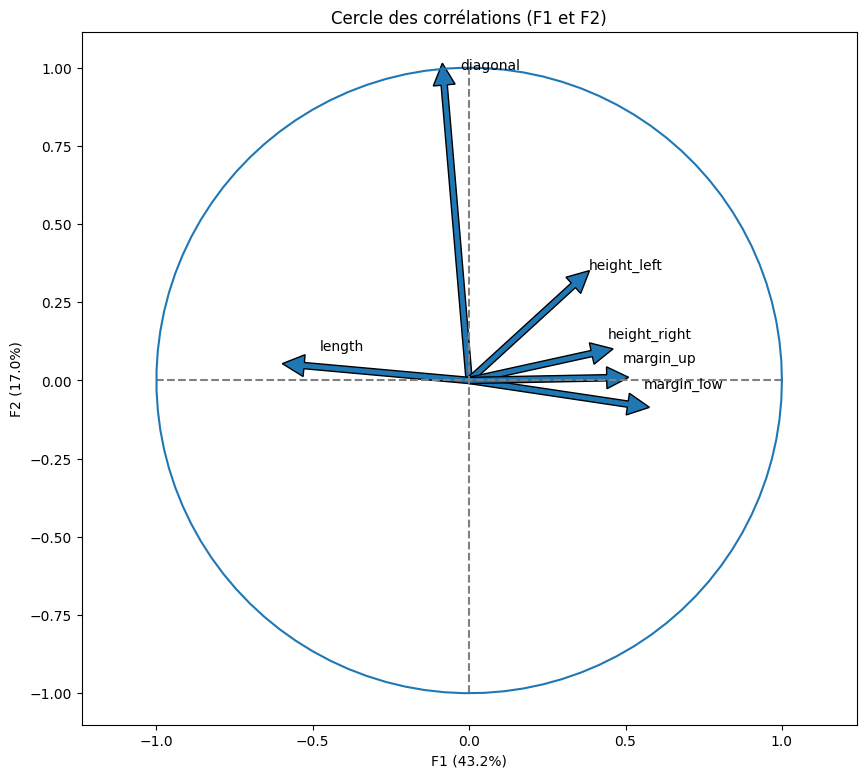

In [94]:
correlation_graph(pca, (0,1), features)

### Eboulis des valeurs propres

In [95]:
var=pca.explained_variance_ratio_ #variance de chaque catégorie
varcum=pca.explained_variance_ratio_.cumsum() #variance cumulée
x_list = range(1, n_components+1)


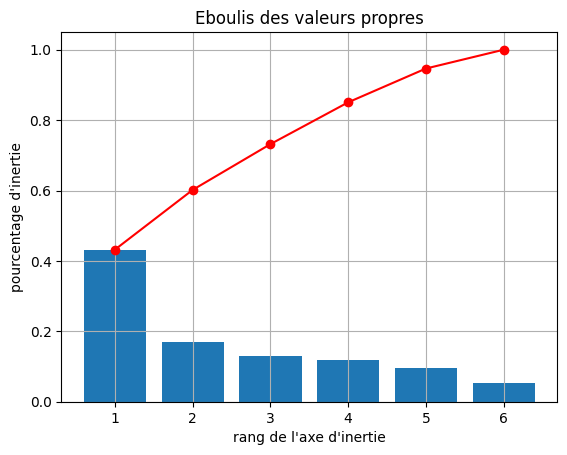

In [96]:
plt.bar(x_list, var)
plt.plot(x_list, varcum,c='red',marker='o')
plt.xlabel("rang de l'axe d'inertie")
plt.ylabel("pourcentage d'inertie")
plt.title("Eboulis des valeurs propres")
plt.grid()
plt.show()

### Components

In [97]:
x_list = range(1, n_components+1)
pcs = pd.DataFrame(pca.components_) # On obtient les composantes que l'on transforme en dataframe
pcs.columns = features # On utilise les catégories de notre df utilisé pour les clusters
pcs.index = [f"F{i}" for i in x_list] #On indexe F1, F2...
pcs.round(2) #On arrondi pour une lecture plus simple

,diagonal,height_left,height_right,margin_low,margin_up,length
F1,-0.08,0.33,0.39,0.51,0.44,-0.53
F2,0.94,0.30,0.09,-0.08,0.01,0.05
F3,-0.28,0.88,-0.21,-0.09,-0.27,0.14
F4,0.09,0.00,-0.87,0.11,0.44,-0.18
F5,-0.13,0.13,0.21,-0.57,0.71,0.30
F6,0.01,0.00,0.01,0.63,0.18,0.76


Les variables qui influent le plus sur F1 sont : height_right	margin_low	margin_up	length

### Projections

In [98]:
X_proj = pca.transform(X)

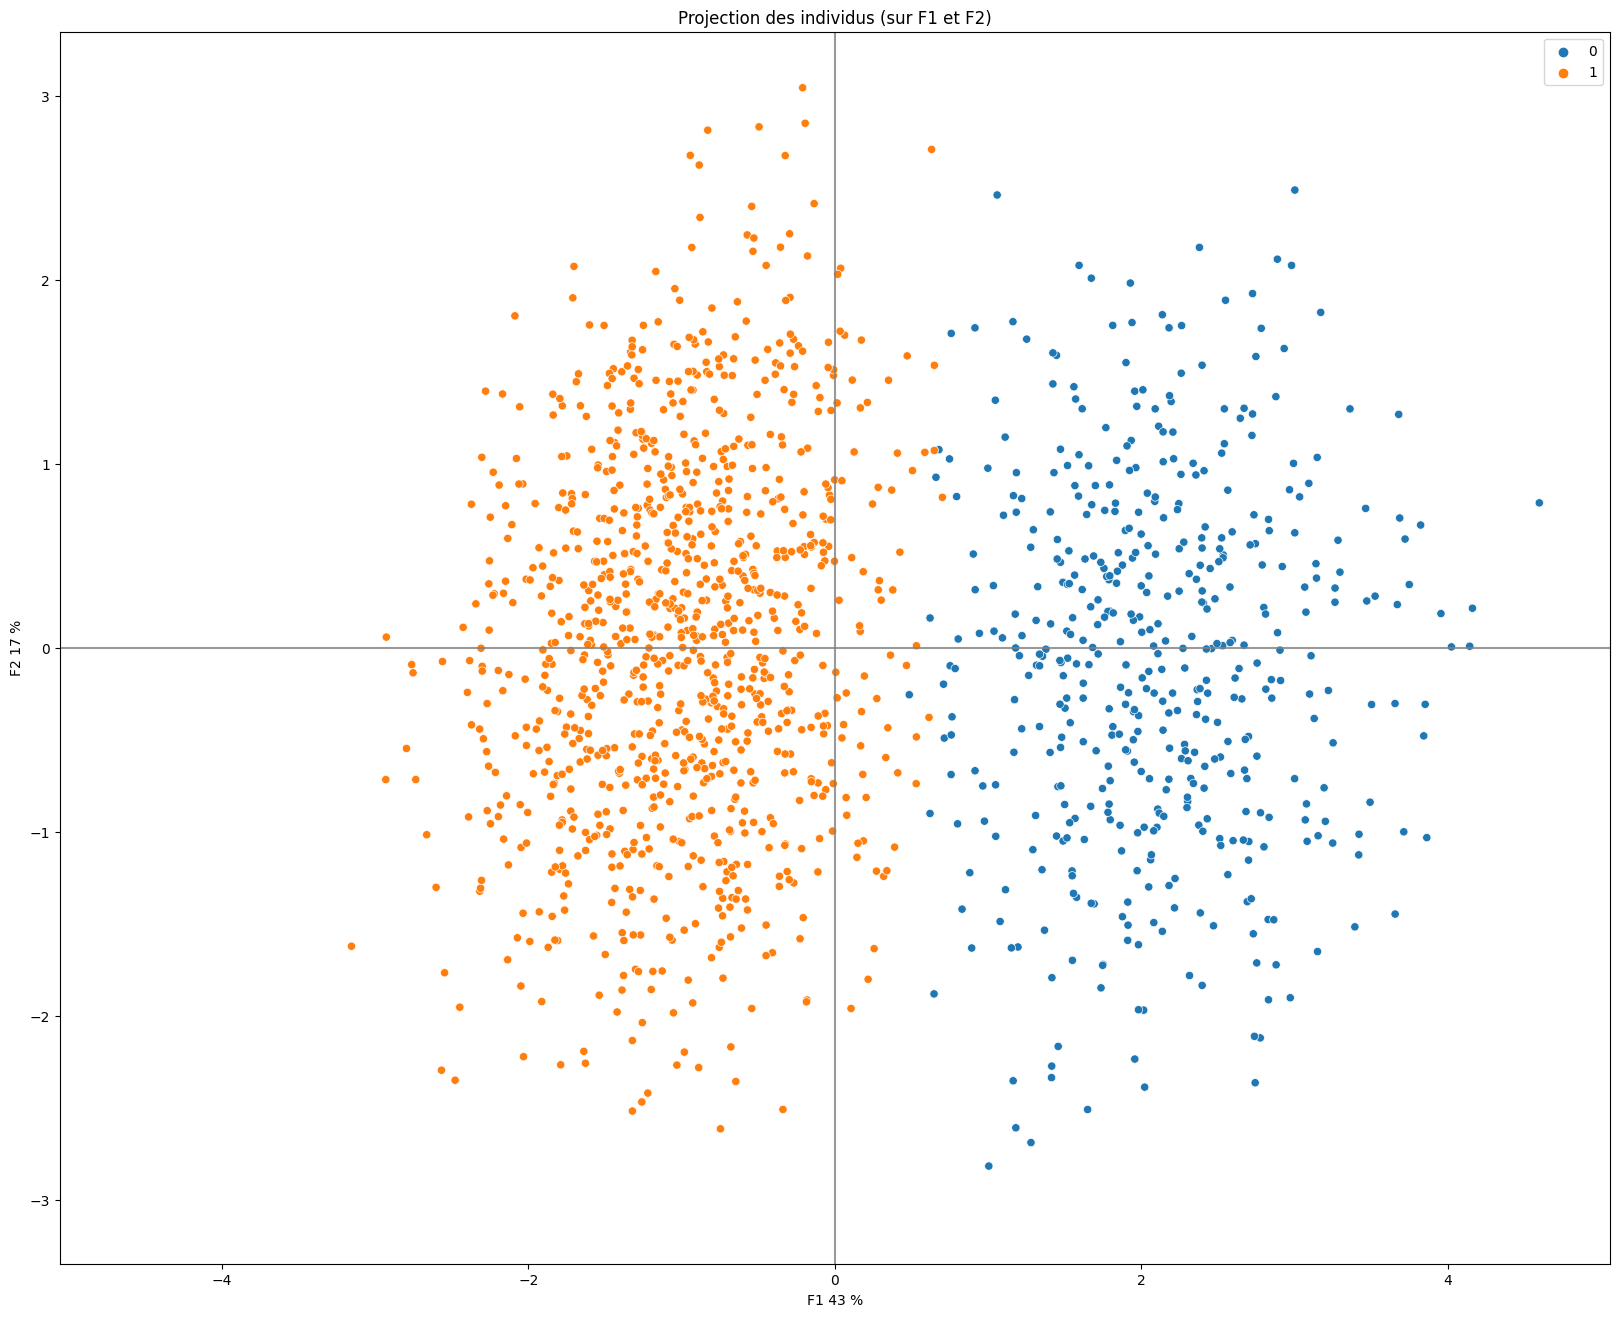

In [99]:
display_factorial_planes(X_proj, (0,1), pca,figsize=(20,16),  clusters=labels, marker="o")

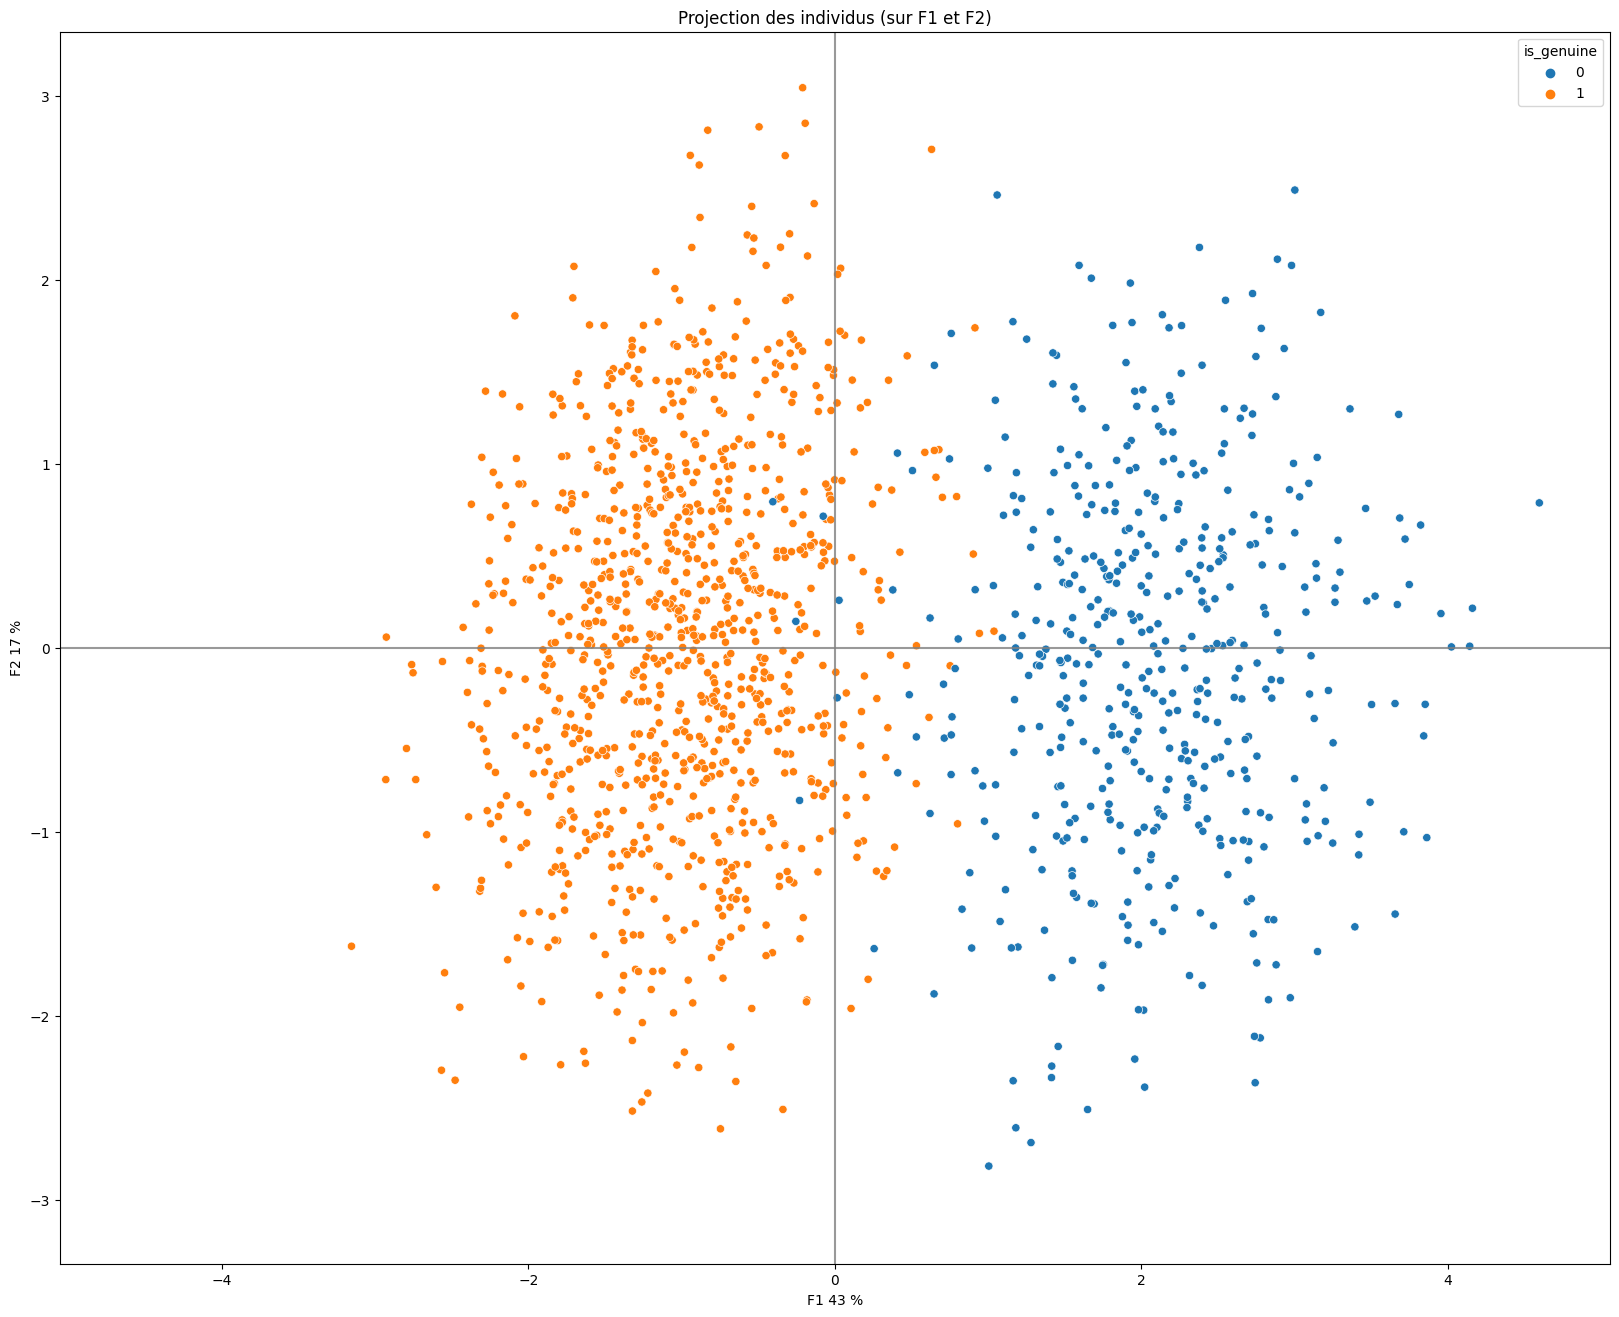

In [100]:
display_factorial_planes(X_proj, (0,1), pca,figsize=(20,16),  clusters=df['is_genuine'], marker="o")

## Regression logistique

In [101]:
df.rename(columns={'is_genuine' : 'target'},inplace=True)
df.head()

,target,diagonal,height_left,height_right,margin_low,margin_up,length
0,1,171.46,103.36,103.66,3.77,2.99,113.09
1,1,172.69,104.48,103.50,4.40,2.94,113.16
2,1,171.36,103.91,103.94,3.62,3.01,113.51
3,1,171.73,104.28,103.46,4.04,3.48,112.54
4,1,172.17,103.74,104.08,4.42,2.95,112.81


### Split data

In [102]:
X=df.drop(columns='target')
y=df['target']

In [103]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1180, 6)
(296, 6)
(1180,)
(296,)


### Normalisation

In [104]:
scaler = StandardScaler()

# on fit sur nos données d'entrainement et on transforme sur toutes

scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

### Entraineur naïf

On va commencer par entrainer un modèle naïf, qui nous donnera le minimum attendu pour notre modèle de regression logistique

In [105]:
estimator = DummyClassifier(strategy='most_frequent')
estimator.fit(X_train,y_train)

DummyClassifier(strategy='most_frequent')

In [106]:
y_pred=estimator.predict(X_test)
y_pred

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64)

Il n'y a qu'une seule valeur. l'estimateur renvoie la valeure la plus fréquente, à savoir Vrai

In [107]:
display(y_test.value_counts(normalize=True).round(2))
display(y_train.value_counts(normalize=True).round(2))

target
1    0.7
0    0.3
Name: proportion, dtype: float64

target
1    0.67
0    0.33
Name: proportion, dtype: float64

Notre fourchette d'amélioration se situe au dessus de ces scores là. 

In [108]:
score(estimator)

score train : 0.6653 score test: 0.7027


In [109]:
confusion(y_test,y_pred)

,pred_0,pred_1
test_0,0,88
test_1,0,208


### Regression logistique scikit

A Noter : 
- Nous prenons ici toutes les variables, néanmoins il est envisageable de prendre les variables qui ont le plus d'impact dans la définition des clusters comme vu lors de l'ACP et de la projection.
- En utilisant stats model, on peut effectuer un backward process pour garder uniquement les variables influentes.

In [110]:
estimator = LogisticRegression()
estimator.fit(X_train,y_train)

LogisticRegression()

In [111]:
y_pred=estimator.predict(X_test)
y_pred

array([0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0,
       0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0,
       0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0,
       1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0,
       0, 1, 1, 1, 1, 1, 0, 0, 0, 0], dtype=int64)

### Histogramme des probabilités

In [112]:
y_prob=estimator.predict_proba(X_test).round(2)
y_prob[:10]

array([[1.  , 0.  ],
       [0.  , 1.  ],
       [1.  , 0.  ],
       [0.  , 1.  ],
       [0.  , 1.  ],
       [0.02, 0.98],
       [0.  , 1.  ],
       [0.13, 0.87],
       [0.  , 1.  ],
       [0.  , 1.  ]])

C:\Users\boisj\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


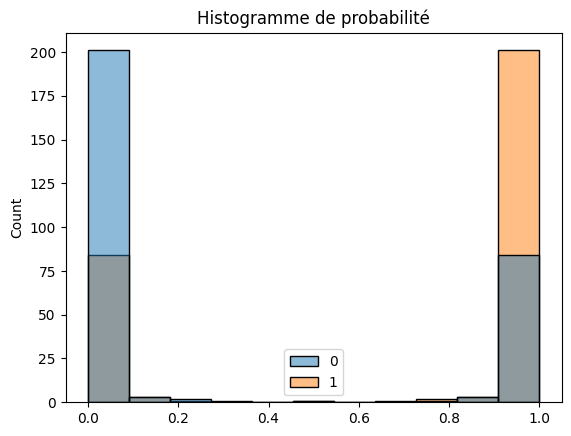

In [113]:
sns.histplot(y_prob)
plt.title('Histogramme de probabilité')
plt.show()

Le modèle est assez fiable au niveau de ses prédictions, la plupart des prédictions ont une probabilité proche de 0 ou de 1.

### Scores de notre modèle

In [114]:
score(estimator)
confusion(y_test,y_pred)

score train : 0.9924 score test: 0.9932


,pred_0,pred_1
test_0,87,1
test_1,1,207


In [115]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99        88
           1       1.00      1.00      1.00       208

    accuracy                           0.99       296
   macro avg       0.99      0.99      0.99       296
weighted avg       0.99      0.99      0.99       296



Les scores du modèles sont très bons

In [116]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test,y_pred)
roc_auc=auc(false_positive_rate, true_positive_rate).round(2)
print(roc_auc)

0.99


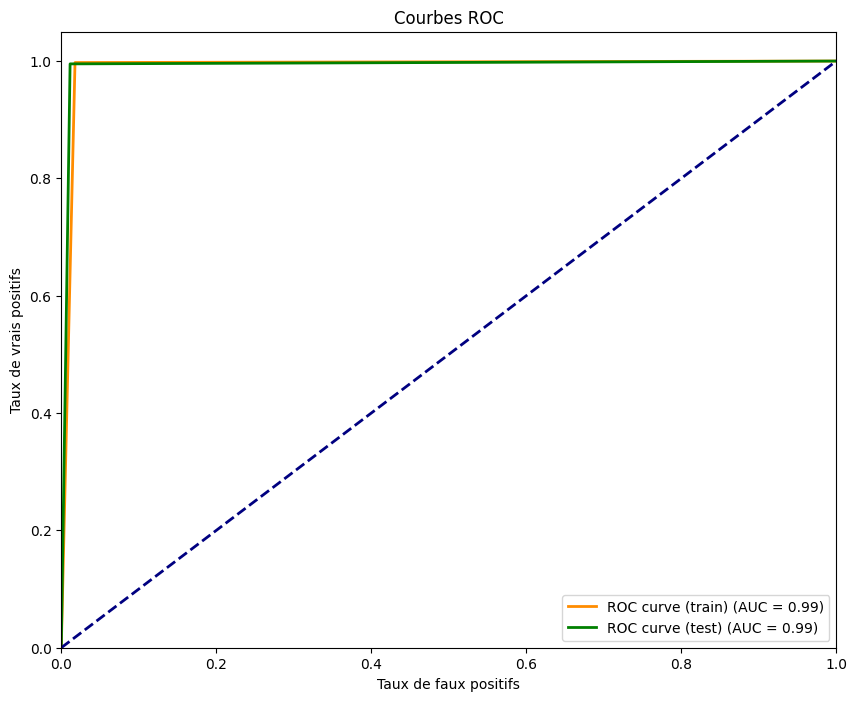

In [117]:
# Obtenir les prédictions du modèle sur l'ensemble d'entraînement et de test
y_train_pred = estimator.predict(X_train)
y_test_pred = estimator.predict(X_test)

# Calculer les courbes ROC et les aires sous la courbe (AUC)
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_pred)
roc_auc_train = auc(fpr_train, tpr_train)

fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_pred)
roc_auc_test = auc(fpr_test, tpr_test)

# Tracer les courbes ROC
plt.figure(figsize=(10, 8))
plt.plot(fpr_train, tpr_train, color='darkorange', lw=2, label='ROC curve (train) (AUC = %0.2f)' % roc_auc_train)
plt.plot(fpr_test, tpr_test, color='green', lw=2, label='ROC curve (test) (AUC = %0.2f)' % roc_auc_test)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbes ROC')
plt.legend(loc="lower right")
plt.show()

### Export du modèle

In [118]:
import pickle

# Sauvegarder le modèle dans un fichier
with open('estimator_scikit.pkl', 'wb') as fichier_modele:
    pickle.dump(estimator, fichier_modele)

### Amélioration du modèle

On peut tenter d'améliorer encore notre modèle à l'aide des hyperparamètres de la regression

In [119]:
estimator2=LogisticRegression(max_iter=1000, random_state=42)
params = {'C': np.logspace(-3,3,7),
          'penalty' : ['l2'],
          'solver': ['newton-cg', 'lbfgs', 'liblinear'],
          'class_weight': [{0: 1, 1: v} for v in np.linspace(1, 20, 30)]}

In [120]:
def min_recall_precision(y_true, y_pred):
    recall = recall_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    return min(recall, precision)

make_scorer(min_recall_precision, greater_is_better=False)

make_scorer(min_recall_precision, greater_is_better=False)

In [121]:
def min_recall_precision(estimator2, X_train, y_train, sample_weight=None):
    y_pred = estimator2.predict(X_train)
    recall = recall_score(y_train, y_pred)
    precision = precision_score(y_train, y_pred)
    return min(recall, precision)

In [122]:
grid=GridSearchCV(estimator2,
                  params,
                  scoring={'precision': make_scorer(precision_score), 'recall': make_scorer(recall_score),'min_both': min_recall_precision},
                  refit='min_both',
                  return_train_score=True,
                  cv=10,
                  n_jobs=-1,
                  verbose=1)

In [123]:
grid.fit(X_train,y_train)

Fitting 10 folds for each of 630 candidates, totalling 6300 fits


GridSearchCV(cv=10,
             estimator=LogisticRegression(max_iter=1000, random_state=42),
             n_jobs=-1,
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'class_weight': [{0: 1, 1: 1.0},
                                          {0: 1, 1: 1.6551724137931034},
                                          {0: 1, 1: 2.310344827586207},
                                          {0: 1, 1: 2.9655172413793105},
                                          {0: 1, 1: 3.6206896551724137},
                                          {0: 1, 1: 4.275862068965517},
                                          {0: 1, 1: 4.931034482758621},...
                                          {0: 1, 1: 18.03448275862069},
                                          {0: 1, 1: 18.689655172413794},
                                          {0: 1, 1: 19.344827586206897},
                                          {0: 1, 1: 20.0}],
                         'penalty': ['l2'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear']},
             refit='min_both', return_train_score=True,
             scoring={'min_both': <function min_recall_precision at 0x0000020E4ED2D120>,
                      'precision': make_scorer(precision_score),
                      'recall': make_scorer(recall_score)},
             verbose=1)

In [124]:
recall_score(y_train,grid.predict(X_train))

0.9974522292993631

In [125]:
recall_score(y_test,grid.predict(X_test))

0.9903846153846154

In [126]:
pd.DataFrame(grid.cv_results_).sort_values('mean_train_min_both',ascending=False)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_class_weight,param_penalty,param_solver,params,split0_test_precision,...,split2_train_min_both,split3_train_min_both,split4_train_min_both,split5_train_min_both,split6_train_min_both,split7_train_min_both,split8_train_min_both,split9_train_min_both,mean_train_min_both,std_train_min_both
540,0.013364,0.002283,0.012717,0.003871,1000.0,"{0: 1, 1: 1.0}",l2,newton-cg,"{'C': 1000.0, 'class_weight': {0: 1, 1: 1.0}, ...",0.987342,...,0.992948,0.991549,0.990155,0.990169,0.991561,0.991561,0.994366,0.991561,0.991696,0.001163
541,0.010572,0.005050,0.012019,0.004712,1000.0,"{0: 1, 1: 1.0}",l2,lbfgs,"{'C': 1000.0, 'class_weight': {0: 1, 1: 1.0}, ...",0.987342,...,0.992948,0.991549,0.990155,0.990169,0.991561,0.991561,0.994366,0.991561,0.991696,0.001163
542,0.004089,0.001133,0.012467,0.002104,1000.0,"{0: 1, 1: 1.0}",l2,liblinear,"{'C': 1000.0, 'class_weight': {0: 1, 1: 1.0}, ...",0.987342,...,0.992948,0.991549,0.990155,0.990169,0.991561,0.991561,0.994366,0.991561,0.991696,0.001163
452,0.004488,0.001428,0.013316,0.004529,100.0,"{0: 1, 1: 1.0}",l2,liblinear,"{'C': 100.0, 'class_weight': {0: 1, 1: 1.0}, '...",0.987342,...,0.992948,0.991549,0.990155,0.990169,0.991561,0.991561,0.992968,0.991561,0.991556,0.000884
450,0.013865,0.002347,0.012467,0.003130,100.0,"{0: 1, 1: 1.0}",l2,newton-cg,"{'C': 100.0, 'class_weight': {0: 1, 1: 1.0}, '...",0.987342,...,0.991549,0.991549,0.990155,0.990169,0.991561,0.991561,0.992968,0.991561,0.991416,0.000754
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82,0.006283,0.001002,0.011868,0.003105,0.001,"{0: 1, 1: 18.689655172413794}",l2,lbfgs,"{'C': 0.001, 'class_weight': {0: 1, 1: 18.6896...",0.669492,...,0.666667,0.666667,0.666038,0.667611,0.666981,0.667611,0.666981,0.667611,0.666950,0.000497
84,0.010124,0.000947,0.011469,0.001624,0.001,"{0: 1, 1: 19.344827586206897}",l2,newton-cg,"{'C': 0.001, 'class_weight': {0: 1, 1: 19.3448...",0.669492,...,0.666667,0.666038,0.666038,0.666981,0.666981,0.667611,0.666981,0.667611,0.666761,0.000564
88,0.006283,0.001997,0.010423,0.001419,0.001,"{0: 1, 1: 20.0}",l2,lbfgs,"{'C': 0.001, 'class_weight': {0: 1, 1: 20.0}, ...",0.669492,...,0.666667,0.666038,0.666038,0.666981,0.666981,0.667611,0.666981,0.667611,0.666761,0.000564
87,0.013664,0.005968,0.011022,0.001898,0.001,"{0: 1, 1: 20.0}",l2,newton-cg,"{'C': 0.001, 'class_weight': {0: 1, 1: 20.0}, ...",0.669492,...,0.666667,0.666038,0.666038,0.666981,0.666981,0.667611,0.666981,0.667611,0.666761,0.000564


In [127]:
best_params={'C': 1000,
 'class_weight': {0: 1, 1: 1.0},
 'penalty': 'l2',
 'solver': 'newton-cg'}


Nous avons les meilleurs paramètres enregistrés. On réentraine notre modèle en précisant ces meilleurs paramètres

In [128]:
estimator2 = LogisticRegression( max_iter=1000, random_state=42, **best_params)
estimator2.fit(X_train,y_train)

LogisticRegression(C=1000, class_weight={0: 1, 1: 1.0}, max_iter=1000,
                   random_state=42, solver='newton-cg')

In [129]:
y_pred=estimator2.predict(X_test)

In [130]:
score(estimator2)
confusion(y_test,y_pred)

score train : 0.9924 score test: 0.9932


,pred_0,pred_1
test_0,87,1
test_1,1,207


In [131]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99        88
           1       1.00      1.00      1.00       208

    accuracy                           0.99       296
   macro avg       0.99      0.99      0.99       296
weighted avg       0.99      0.99      0.99       296



In [132]:
y_prob2=estimator2.predict_proba(X_test).round(2)

C:\Users\boisj\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\boisj\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


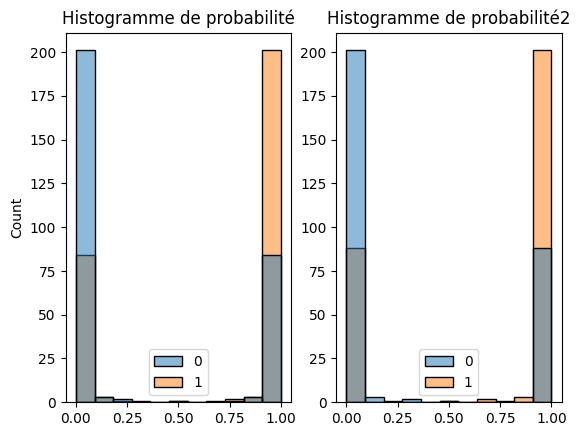

In [133]:
plt.subplot(1, 2, 2)
sns.histplot(y_prob2)
plt.title('Histogramme de probabilité2')

plt.subplot(1, 2, 1)
sns.histplot(y_prob)
plt.title('Histogramme de probabilité')
plt.show()

### Courbe Roc train & test

In [134]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test,y_pred)
roc_auc=auc(false_positive_rate, true_positive_rate).round(2)
print(roc_auc)

0.99


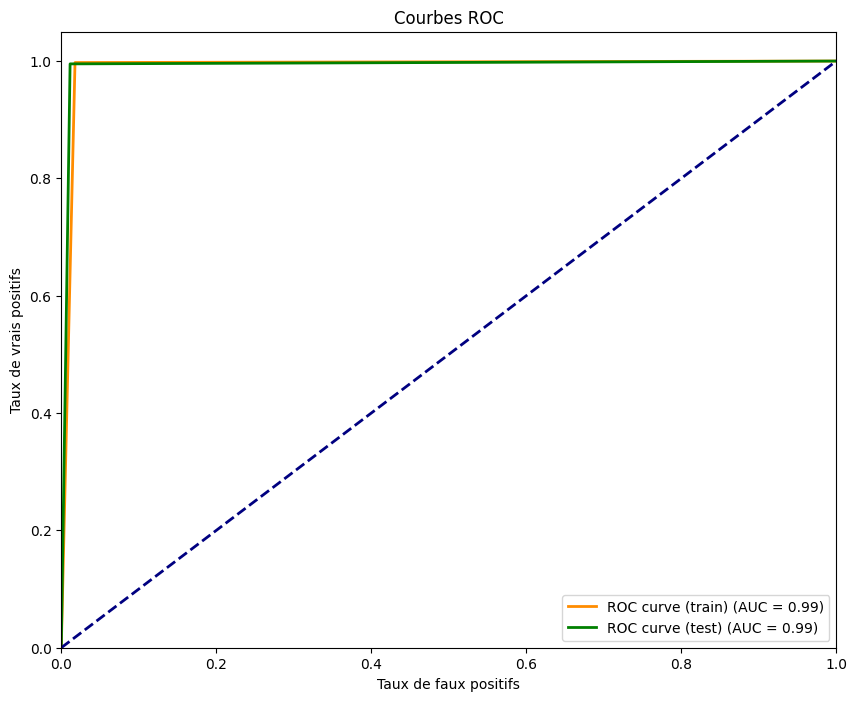

In [135]:
# Obtenir les prédictions du modèle sur l'ensemble d'entraînement et de test
y_train_pred = estimator2.predict(X_train)
y_test_pred = estimator2.predict(X_test)

# Calculer les courbes ROC et les aires sous la courbe (AUC)
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_pred)
roc_auc_train = auc(fpr_train, tpr_train)

fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_pred)
roc_auc_test = auc(fpr_test, tpr_test)

# Tracer les courbes ROC
plt.figure(figsize=(10, 8))
plt.plot(fpr_train, tpr_train, color='darkorange', lw=2, label='ROC curve (train) (AUC = %0.2f)' % roc_auc_train)
plt.plot(fpr_test, tpr_test, color='green', lw=2, label='ROC curve (test) (AUC = %0.2f)' % roc_auc_test)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbes ROC')
plt.legend(loc="lower right")
plt.show()

### Export du modèle

In [136]:
# Sauvegarder le modèle dans un fichier
with open('estimator2_scikit.pkl', 'wb') as fichier_modele:
    pickle.dump(estimator2, fichier_modele)